In [ ]:
import pandas
import numpy
import io
import requests
import seaborn
import matplotlib.pyplot as plt
import tensorflow
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [0]:
def create_dataset_train(X_train, y_train):
  dataset_train = pandas.merge(X_train, y_train)
  return dataset_train

def create_dataset_test(X_test):
  X_test_columns = []
  for i in X_test.columns:
    X_test_columns.append(i)
  X_test_columns.append('target')
  dataset_test = pandas.DataFrame(X_test, columns=X_test_columns)
  return dataset_test

def create_full_dataset(dataset_train, dataset_test):
  dataset_full = pandas.concat([dataset_train, dataset_test], ignore_index=True, sort=False)
  return dataset_full

def mutual_information(X_train, y_train):
  mi = mutual_info_classif(df_train.drop(['target'], axis=1), df_train['target'])
  mi = pandas.Series(mi)
  mi.index = df_train.drop(['target'], axis=1).columns
  mi = mi.sort_values(ascending=False)
  return mi

def build_model(n_layers, neurons, dimension, f_activation, dropout=False, do_rate=None):
  model = Sequential()
  model.add(Dense(neurons[0], input_dim=dimension, activation=f_activation[0]))
  if dropout == True:
    model.add(Dropout(do_rate[0]))
  for i in range(0, n_layers):
    model.add(Dense(neurons[i+1], activation=f_activation[i+1]))
    if dropout == True:
      model.add(Dropout(do_rate[i+1]))
  model.add(Dense(1, activation=f_activation[-1]))
  return model

def create_predict_dataset(dataset_test, y_pred):
  for i in range(0, y_pred.shape[0]):
    dataset_test.at[i, 'target'] = y_pred[i]
  return dataset_test

def plot_acc_loss(fit_history):
  plt.figure(figsize=(34, 16))

  plt.subplot(235)
  plt.plot(fit_history.history['binary_accuracy'], color='green')
  plt.title('Model binary accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')

  plt.subplot(236)
  plt.plot(fit_history.history['loss'], color='red')
  plt.title('Model binary crossentropy loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')

  plt.show()

def return_metrics(confusion_matrix):
  true_positive, false_negative, false_positive, true_negative = confusion_matrix.ravel()
  prec = (true_positive/(true_positive + false_positive))*100
  recall = (true_positive/(true_positive + false_negative))*100
  f1 = 2*((prec*recall)/(prec+recall))
  return prec, recall, f1

In [0]:
url_X_train = 'https://media.githubusercontent.com/media/fbarth/ml-espm/master/data/transacoes_financeiras_x_treinamento.csv'
url_y_train = 'https://media.githubusercontent.com/media/fbarth/ml-espm/master/data/transacoes_financeiras_y_treinamento.csv'
url_X_test = 'https://media.githubusercontent.com/media/fbarth/ml-espm/master/data/transacoes_financeiras_x_teste.csv'

s_X_train = requests.get(url_X_train).content
s_y_train = requests.get(url_y_train).content
s_X_test = requests.get(url_X_test).content

X_train = pandas.DataFrame(pandas.read_csv(io.StringIO(s_X_train.decode('utf-8')), sep=","))
y_train = pandas.DataFrame(pandas.read_csv(io.StringIO(s_y_train.decode('utf-8')), sep=","))
X_test = pandas.DataFrame(pandas.read_csv(io.StringIO(s_X_test.decode('utf-8')), sep=","))

In [4]:
y_just_train = y_train.drop(['Unnamed: 0'], axis=1)
pandas.DataFrame([y_just_train[y_just_train.target == 0].values[0][0], y_just_train[y_just_train.target == 1].values[0][0]], columns=['target'])

,target
0,0
1,1


In [5]:
qtd0_train, qtd1_train = y_train['target'].value_counts()
print('Quantidades de 0s -> %s\nQuantidades de 1s -> %s' % (qtd0_train, qtd1_train))

Quantidades de 0s -> 143806
Quantidades de 1s -> 16194


In [6]:
df_train = create_dataset_train(X_train, y_train)
df_test = create_dataset_test(X_test)
df_full = create_full_dataset(df_train, df_test)

print('Dataset de treino: %s\nDataset de teste: %s\nDataset completo: %s' % (df_train.shape, df_test.shape, df_full.shape))

Dataset de treino: (160000, 202)
Dataset de teste: (40000, 202)
Dataset completo: (200000, 202)


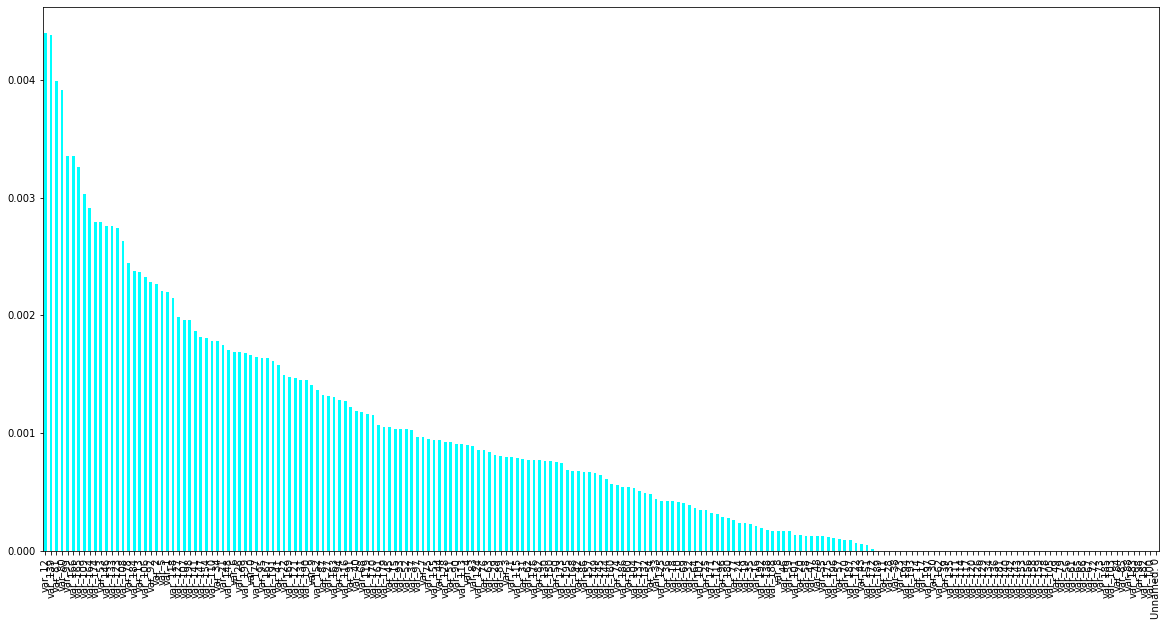

In [7]:
mi = mutual_information(df_train.drop(['target'], axis=1), df_train['target'])
mi.plot.bar(figsize=(20, 10), color='cyan')

In [0]:
skb_ = SelectKBest(mutual_info_classif, k=10).fit(df_train.drop(['target'], axis=1), df_train['target'])

In [9]:
k_best = list(df_train.drop(['target'], axis=1).columns[skb_.get_support()])
print('Melhores features\n----------------------------------------------------------------------------------\n%s'
      % (df_train.drop(['target'], axis=1).columns[skb_.get_support()].values))

Melhores features
----------------------------------------------------------------------------------
['var_12' 'var_53' 'var_80' 'var_81' 'var_99' 'var_133' 'var_139'
 'var_146' 'var_165' 'var_166']


In [15]:
neurons = [32, 32]
f_activation = ['relu', 'relu', 'sigmoid']

mlp = build_model(1, neurons, 10, f_activation)

mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
fit_history = mlp.fit(df_train[k_best].values, df_train['target'].values, epochs=8, verbose=1)

Epoch 1/8
160000/160000 [==============================] - 7s 44us/step - loss: 0.3258 - binary_accuracy: 0.8964
Epoch 2/8
160000/160000 [==============================] - 7s 43us/step - loss: 0.3128 - binary_accuracy: 0.8989
Epoch 3/8
160000/160000 [==============================] - 7s 42us/step - loss: 0.3108 - binary_accuracy: 0.8990
Epoch 4/8
160000/160000 [==============================] - 7s 42us/step - loss: 0.3100 - binary_accuracy: 0.8988
Epoch 5/8
160000/160000 [==============================] - 7s 43us/step - loss: 0.3094 - binary_accuracy: 0.8990
Epoch 6/8
160000/160000 [==============================] - 7s 42us/step - loss: 0.3087 - binary_accuracy: 0.8990
Epoch 7/8
160000/160000 [==============================] - 7s 43us/step - loss: 0.3085 - binary_accuracy: 0.8991
Epoch 8/8
160000/160000 [==============================] - 7s 42us/step - loss: 0.3081 - binary_accuracy: 0.8989


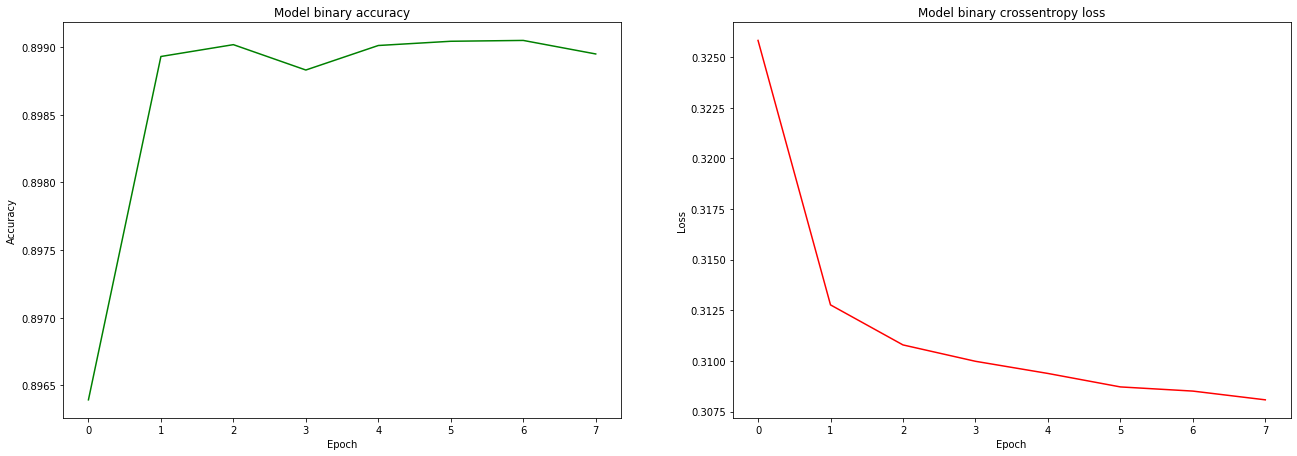

In [16]:
plot_acc_loss(fit_history)

In [17]:
y_pred_train = mlp.predict_classes(df_train[k_best].values)
cm = confusion_matrix(df_train['target'].values, y_pred_train)

loss, acc = mlp.evaluate(df_train[k_best].values, df_train['target'].values, verbose=0)
prec, recall, f1 = return_metrics(cm)

print('Loss: %.2f%s\nAccuracy: %.2f%s\nPrecision: %.2f%s\nRecall: %.2f%s\nF1 Score: %.2f%s'
      % (loss*100, '%', acc*100, '%', prec, '%', recall, '%', f1, '%'))

Loss: 30.84%
Accuracy: 89.91%
Precision: 89.99%
Recall: 99.88%
F1 Score: 94.68%


In [18]:
y_pred_test = mlp.predict_classes(df_test[k_best].values)
df_test = create_predict_dataset(df_test, y_pred_test)

qtd0_pred, qtd1_pred = df_test['target'].value_counts()
print('Quantidades de 0s -> %s\nQuantidades de 1s -> %s' % (qtd0_pred, qtd1_pred))

Quantidades de 0s -> 39927
Quantidades de 1s -> 73


In [19]:
print('Valores absolutos\n--------------------------------\nLoss: %s\nAccuracy: %s\nPrecision: %s\nRecall: %s\nF1 Score: %s' % (loss, acc, prec/100, recall/100, f1/100))

Valores absolutos
--------------------------------
Loss: 0.3084469366587698
Accuracy: 0.89905
Precision: 0.89988847956294
Recall: 0.9987969903898307
F1 Score: 0.9467665069310326
